# The notebook to evaluate the clique finding algorithms

In [1]:
import random
import json
import time
import networkx as nx
import matplotlib.pyplot as plt

from pathlib import Path
from functools import wraps
from typing import Set, List, Tuple

## Clique generation libs

In [3]:
def generate_clique(n: int) -> nx.Graph:
    return nx.complete_graph(n)


def generate_multiple_cliques(sizes: list, connections: int = 0) -> nx.Graph:
    G: nx.Graph = nx.Graph()
    offset: int = 0
    clique_nodes: list = []
    
    # Generate each clique
    for size in sizes:
        nodes = list(range(offset, offset + size))
        clique_nodes.append(nodes)
        clique = generate_clique(size)
        # Relabel nodes to avoid conflicts
        mapping = {i: i + offset for i in range(size)}
        clique = nx.relabel_nodes(clique, mapping)
        G.add_edges_from(clique.edges())
        offset += size
    
    # Add random connections between cliques
    for _ in range(connections):
        clique1, clique2 = random.sample(clique_nodes, 2)
        node1 = random.choice(clique1)
        node2 = random.choice(clique2)
        G.add_edge(node1, node2)
    
    return G

def generate_random_graph_config( min_size: int = 3, max_size: int = 10, min_value: int = 1, max_value: int = 100 ) -> Tuple[List[int], int, str]:
    """
    Generate a random list and a target number within [0, sum(list)].
    
    Args:
        min_size: Minimum length of the list
        max_size: Maximum length of the list
        min_value: Minimum value for list elements
        max_value: Maximum value for list elements
    """
    size = random.randint(min_size, max_size)
    cliques = [random.randint(min_value, max_value) for _ in range(size)]
    
    total = sum(cliques)
    connections = random.randint(0, total)
    
    filename = f"multiple_clique_graph_{'_'.join(map(str, cliques))}.json"
    return cliques, connections, filename


## Clique visualization libs

In [4]:
def visualize_graph(G: nx.Graph, title: str="Graph Visualization"):
    plt.figure(figsize=(20, 20))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', 
            node_size=500, font_size=10, font_weight='bold')
    plt.title(title)
    plt.show()

def visualize_graph_customized(G: nx.Graph, title: str="Graph Visualization", 
                   node_color: str = 'lightblue', 
                   node_size: int = 1000,
                   font_size: int = 12,
                   layout: str = 'spring'):
   
    plt.figure(figsize=(5, 5))
    
    layout_funcs: dict = {
        'spring': nx.spring_layout,
        'circular': nx.circular_layout,
        'random': nx.random_layout,
        'shell': nx.shell_layout
    }
    
    layout_func = layout_funcs.get(layout, nx.spring_layout)
    pos = layout_func(G)
    
    nx.draw(G, pos,
            with_labels=True,
            node_color=node_color,
            node_size=node_size,
            font_size=font_size,
            font_weight='bold',
            edge_color='gray',
            width=2,
            alpha=0.8)
    
    plt.title(title, fontsize=16, pad=20)
    plt.show()

## Clique analysis libs

In [5]:
def analyze_graph(G: nx.Graph):
    
    print("Graph Analysis:")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
    print(f"Density: {nx.density(G):.3f}")
    
    if nx.is_connected(G):
        print(f"Average shortest path length: {nx.average_shortest_path_length(G):.2f}")
        print(f"Diameter: {nx.diameter(G)}")
    else:
        print("Graph is not connected")
    
    # print("Node degrees:")
    # for node, degree in G.degree():
    #     print(f"\t{node}: {degree}")
        # Find all cliques and sort by size
    
    cliques = list(nx.find_cliques(G))
    cliques.sort(key=len, reverse=True)
    
    print("\n5 Largest Cliques:")
    for i, clique in enumerate(cliques[:5], 1):
        print(f"\tClique {i}: Size={len(clique)}, Nodes={clique}")

    # print("Cliques in graph:")
    # for i, clique in enumerate(nx.find_cliques(G), 1):
    #     print(f"\tClique {i}: {clique}")

def calculate_correlation(list1, list2, handle_different_lengths='error'):
    """
    Calculate matching ratio between two lists of strings.
    
    Args:
        list1: First list of strings
        list2: Second list of strings
        handle_different_lengths: How to handle different length lists
            'error' - raise ValueError
            'truncate' - use overlapping parts
    
    Returns:
        Ratio of matching strings
    """
    if len(list1) != len(list2):
        if handle_different_lengths == 'error':
            raise ValueError(f"Lists have different lengths: {len(list1)} vs {len(list2)}")
        elif handle_different_lengths == 'truncate':
            # Use the length of the shorter list
            min_length = min(len(list1), len(list2))
            list1 = list1[:min_length]
            list2 = list2[:min_length]
            print(f"Warning: Lists truncated to length {min_length}")
    
    n = len(list1)
    if n == 0:
        raise ValueError("Lists are empty")
    
    # Count matching strings
    matches = sum(1 for x, y in zip(list1, list2) if x == y)
    return matches / n

def create_comparison_table(data_dict, title="String Matching Table", handle_different_lengths='truncate'):
    """
    Create a simple table showing string matching ratios.
    """
    variables = list(data_dict.keys())
    n = len(variables)
    
    # Calculate matching matrix
    match_matrix = []
    for var1 in variables:
        row = []
        for var2 in variables:
            try:
                match_ratio = calculate_correlation(
                    data_dict[var1], 
                    data_dict[var2],
                    handle_different_lengths
                )
                row.append(match_ratio)
            except ValueError as e:
                print(f"Error calculating matches between {var1} and {var2}: {e}")
                row.append(float('nan'))
        match_matrix.append(row)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.axis('off')
    
    # Create table
    table = ax.table(
        cellText=[[f'{x:.2f}' if not isinstance(x, str) else x 
                   for x in row] for row in match_matrix],
        rowLabels=variables,
        colLabels=variables,
        cellLoc='center',
        loc='center',
        bbox=[0.2, 0.2, 0.6, 0.6]
    )
    
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.5)
    
    plt.title(title, pad=20)
    plt.show()


## Clique storage libs

In [6]:
def graph_to_json(G: nx.Graph, filename: str, is_single_clique: bool = False) -> dict:
    default_weight: int= 1

    single_output_folder: Path = Path("graphs/single/")
    multiple_output_folder: Path = Path("graphs/multiple/")
    output: Path = None

    if check_directories(single_output_folder, create=True):
        print(f"Created directories for: {single_output_folder}")
    else:
        print(f"Directory does not exist: {single_output_folder}")

    if check_directories(multiple_output_folder, create=True):
        print(f"Created directories for: {multiple_output_folder}")
    else:
        print(f"Directory does not exist: {multiple_output_folder}")

    if is_single_clique:
        output = single_output_folder / filename
    else:
        output = multiple_output_folder / filename

    graph: dict = {}
    
    for node in G.nodes():
        neighbors: dict = {}
        for neighbor in G.neighbors(node):
            connection: int = G.get_edge_data(node, neighbor).get('weight', default_weight)
            neighbors[neighbor] = connection
        
        graph[node] = neighbors
    
    # Write to JSON file
    with open(output, 'w') as f:
        json.dump(graph, f, indent=4)
    
    return graph

def check_directories(path: Path, create: bool =False) -> bool:
    if create:
        path.mkdir(parents=True, exist_ok=True)
        return True
    return path.exists()

def load_graph_from_json(json_path: Path) -> nx.Graph:
    G: nx.Graph = nx.Graph()
   
    with open(json_path, 'r') as f:
        adj_list = json.load(f)
    
        for node, neighbors in adj_list.items():
            for neighbor in neighbors:
                G.add_edge(node, neighbor)

    return G

## Generate and visualize a single clique

Created directories for: graphs/single
Created directories for: graphs/multiple


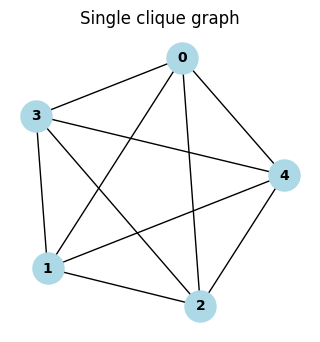

Graph Analysis:
Number of nodes: 5
Number of edges: 10
Average degree: 4.00
Density: 1.000
Average shortest path length: 1.00
Diameter: 1

5 Largest Cliques:
	Clique 1: Size=5, Nodes=[0, 1, 2, 3, 4]
Cliques in graph:
	Clique 1: [0, 1, 2, 3, 4]


In [106]:
single_clique_graph: nx.Graph = generate_clique(5)
single_clique_graph_dict : dict = graph_to_json(single_clique_graph, filename="single_clique_graph-2.json", is_single_clique=True)
visualize_graph(single_clique_graph, title="Single clique graph")
# visualize_graph_customized(single_clique_graph, title="Single clique graph spring", node_size=1000, layout="spring")
# visualize_graph_customized(single_clique_graph, title="Single clique graph circular", node_size=1000, layout="circular")
# visualize_graph_customized(single_clique_graph, title="Single clique graph shell", node_size=1000, layout="shell")

analyze_graph(single_clique_graph)


## Generate and visualize multiple cliques

Cliques: [17, 12]
Connections: 0
Filename: multiple_clique_graph_17_12.json
Created directories for: graphs/single
Created directories for: graphs/multiple


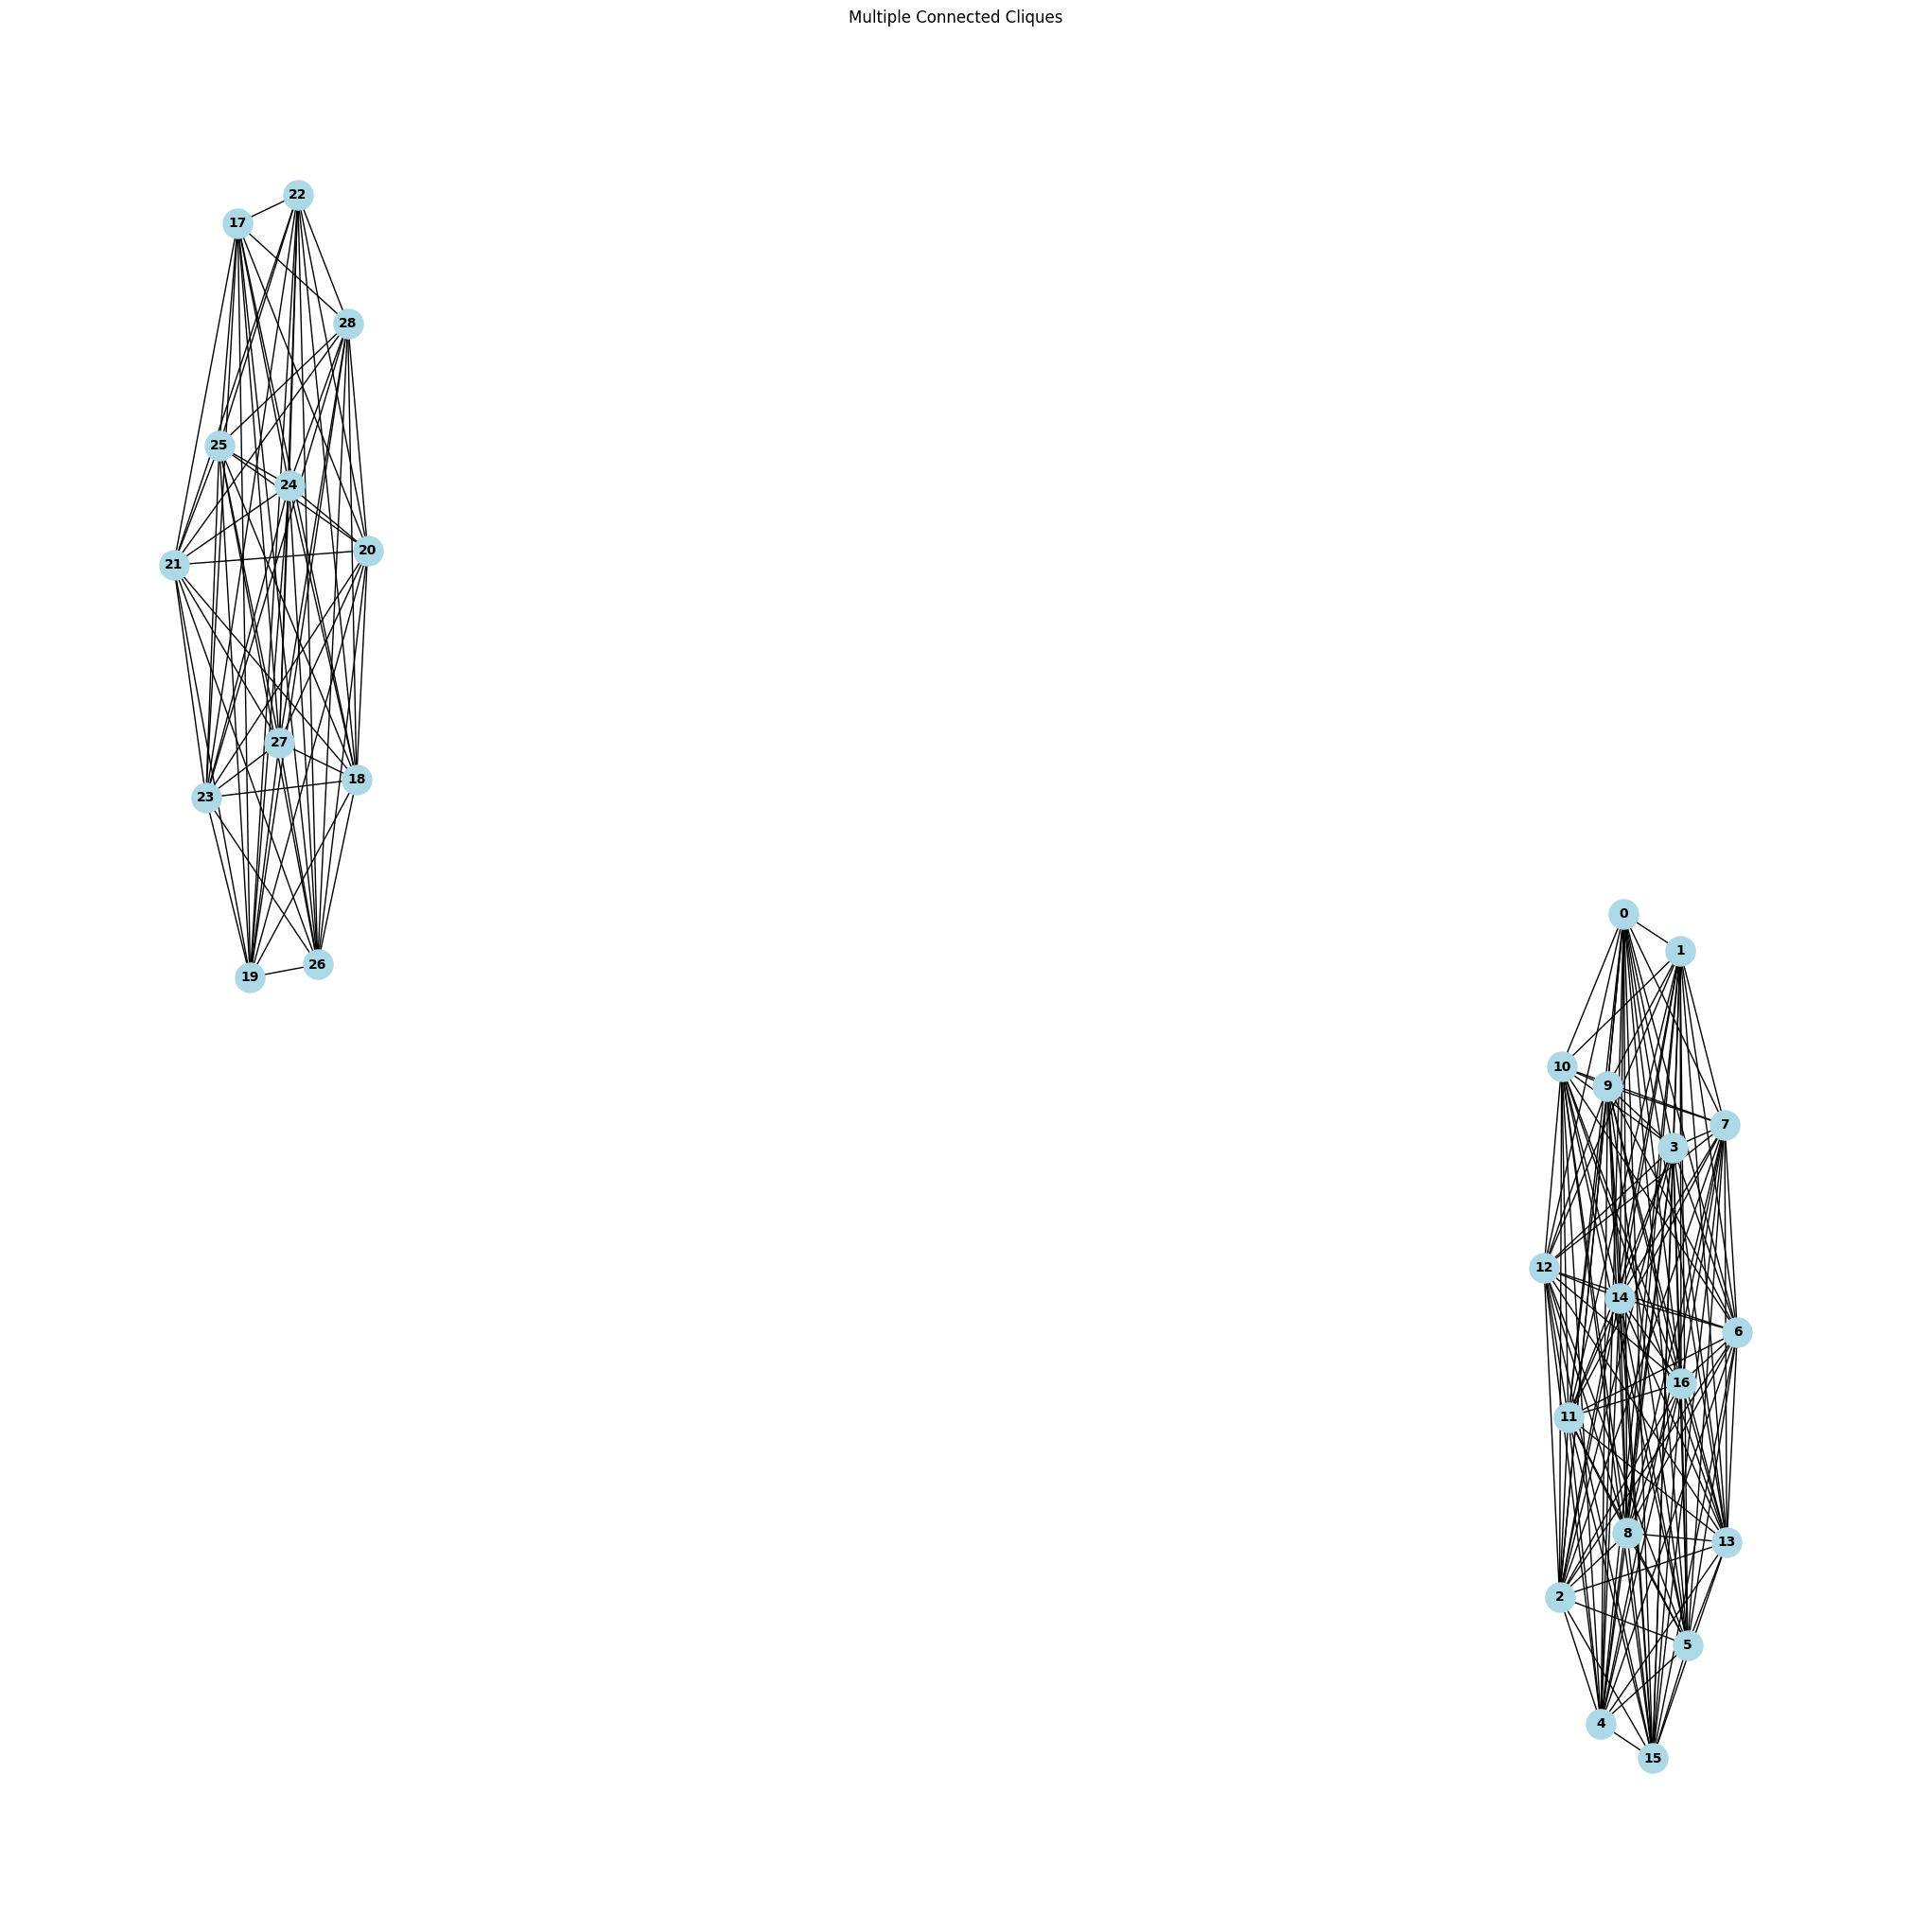

Graph Analysis:
Number of nodes: 29
Number of edges: 202
Average degree: 13.93
Density: 0.498
Graph is not connected

5 Largest Cliques:
	Clique 1: Size=17, Nodes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 13, 14, 15]
	Clique 2: Size=12, Nodes=[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
Cliques in graph:
	Clique 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 13, 14, 15]
	Clique 2: [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]


In [175]:
# clique_sizes: list = [50, 150, 75] 
# interclique_connections: int = 70

clique_sizes, interclique_connections, filename = generate_random_graph_config(min_size=1, max_size=3, min_value=10, max_value=20)
interclique_connections = 0

print(f"Cliques: {clique_sizes}")
print(f"Connections: {interclique_connections}")
print(f"Filename: {filename}")

multi_clique_graph: nx.Graph = generate_multiple_cliques(sizes=clique_sizes, connections=interclique_connections)
multiple_clique_dict : dict = graph_to_json(multi_clique_graph, filename=filename)

visualize_graph(multi_clique_graph, "Multiple Connected Cliques")
# visualize_graph_customized(multi_clique_graph, title="Multiple Connected Cliques spring", node_size=1000, layout="spring")
# visualize_graph_customized(multi_clique_graph, title="Multiple Connected Cliques circular", node_size=1000, layout="circular")
# visualize_graph_customized(multi_clique_graph, title="Multiple Connected Cliques shell", node_size=1000, layout="shell")
# visualize_graph_customized(multi_clique, title="Multiple Connected Cliques random", node_size=1000, layout="random")

analyze_graph(multi_clique_graph)


## Load and analyze graph

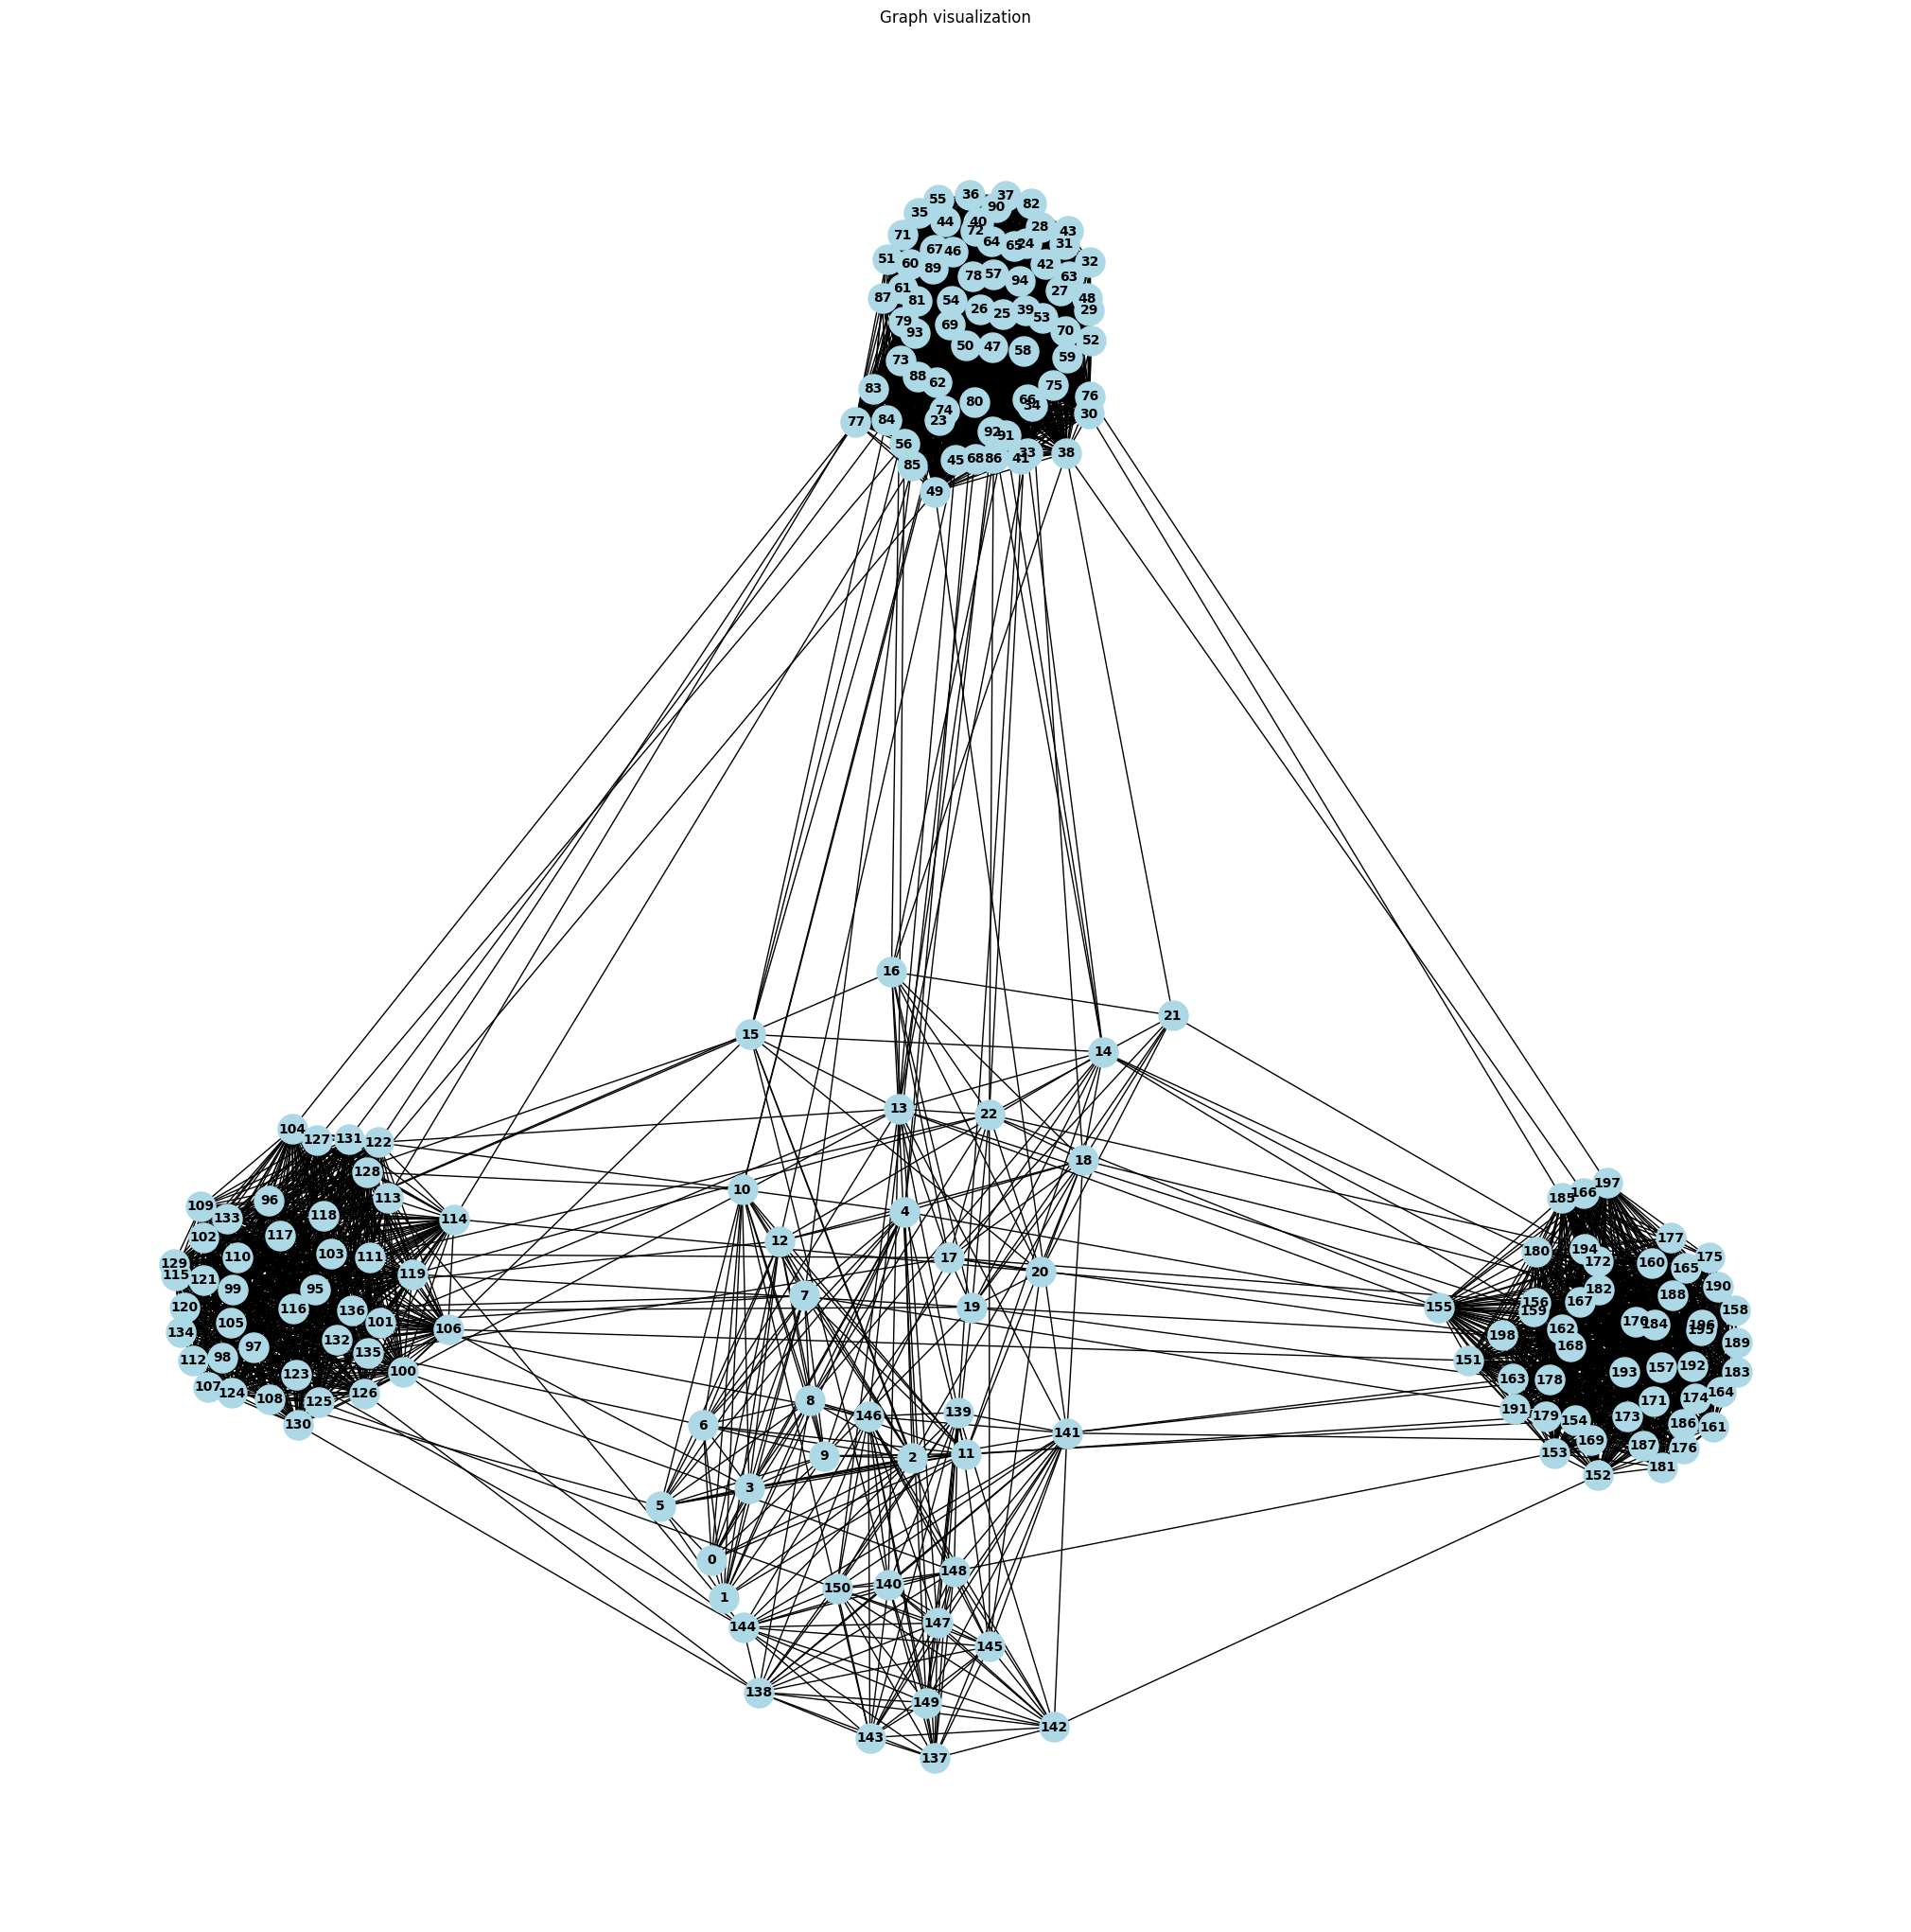

Graph Analysis:
Number of nodes: 199
Number of edges: 4863
Average degree: 48.87
Density: 0.247
Average shortest path length: 2.28
Diameter: 3

5 Largest Cliques:
	Clique 1: Size=72, Nodes=['86', '56', '33', '45', '88', '52', '43', '39', '76', '46', '53', '72', '25', '51', '91', '23', '27', '63', '49', '77', '64', '38', '74', '26', '36', '69', '41', '60', '65', '61', '62', '31', '37', '58', '90', '40', '70', '73', '55', '81', '82', '24', '94', '68', '85', '75', '80', '34', '83', '42', '54', '30', '57', '67', '79', '93', '66', '87', '28', '50', '44', '92', '35', '89', '59', '71', '47', '48', '32', '29', '78', '84']
	Clique 2: Size=48, Nodes=['174', '175', '177', '192', '168', '186', '198', '153', '181', '179', '171', '182', '165', '164', '167', '152', '196', '155', '185', '158', '183', '173', '154', '156', '162', '190', '189', '178', '180', '159', '193', '184', '157', '151', '161', '163', '166', '170', '188', '172', '191', '160', '197', '195', '194', '169', '176', '187']
	Clique 3: Size

In [7]:
filename = Path("graphs/multiple/multiple_clique_graph_13_3_7_72_42_14_48.json")

G: nx.Graph = load_graph_from_json(filename)
visualize_graph(G, "Graph visualization")
# visualize_graph_customized(multi_clique_graph, title="Multiple Connected Cliques spring", node_size=1000, layout="spring")
# visualize_graph_customized(multi_clique_graph, title="Multiple Connected Cliques circular", node_size=1000, layout="circular")
# visualize_graph_customized(multi_clique_graph, title="Multiple Connected Cliques shell", node_size=1000, layout="shell")
# # visualize_graph_customized(multi_clique, title="Multiple Connected Cliques random", node_size=1000, layout="random")

analyze_graph(G)



# Clique finding algorithms 
* Bron-Kerbosh algorithm
* Carraghan-Pardalos algorithm
* Tabu Search algorithm

In [8]:
def timer(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        result = func(*args, **kwargs)
        end = time.perf_counter()
        print(f"{func.__name__} took {end - start:.10f} seconds to execute")
        return result
    return wrapper

### Bron-Kerbosh algorithm

In [9]:
# def bron_kerbosch(graph: nx.Graph, r: Set[int] = None, p: Set[int] = None, x: Set[int] = None) -> List[Set[int]]:
#     """
#     Implements recursive Bron-Kerbosch algorithm with pivot for finding all maximal cliques.
    
#     Parameters:
#         - graph: NetworkX undirected graph
#         - r: Set of vertices in the current clique
#         - p: Set of prospective vertices
#         - x: Set of excluded vertices
    
#     Returns:
#         - List of maximal cliques
#     """

#     if r is None:
#         r = set()
#         p = set(graph.nodes())
#         x = set()
    
#     cliques = []
    
#     if not p and not x:
#         return [r] if r else []
    
#     pivot = max(p.union(x), key=lambda u: len(set(graph.neighbors(u)).intersection(p)), default=None)
    
#     # Iterate through vertices in P \ N(pivot)
#     pivot_neighbors = set(graph.neighbors(pivot)) if pivot is not None else set()
#     for vertex in p.difference(pivot_neighbors):
#         vertex_neighbors = set(graph.neighbors(vertex))
        
#         # Recursive call with updated sets
#         new_r = r.union({vertex})
#         new_p = p.intersection(vertex_neighbors)
#         new_x = x.intersection(vertex_neighbors)
        
#         cliques.extend(bron_kerbosch(graph, new_r, new_p, new_x))
        
#         # Move vertex from P to X
#         p.remove(vertex)
#         x.add(vertex)
    
#     return cliques

# def bron_kerbosch_max_clique(graph: nx.Graph, r: Set[int] = None, p: Set[int] = None, x: Set[int] = None) -> Set[int]:
#     """
#     Modified Bron-Kerbosch algorithm to find the maximum clique in an undirected graph.
    
#     Parameters:
#     - graph: NetworkX undirected graph
#     - r: Set of vertices in the current clique
#     - p: Set of prospective vertices
#     - x: Set of excluded vertices
    
#     Returns:
#     - Set representing the maximum clique found
#     """

#     if r is None:
#         r = set()
#         p = set(graph.nodes())
#         x = set()
    
#     # Store the current maximum clique
#     global max_clique
#     if 'max_clique' not in globals():
#         max_clique = set()
    
#     # Update max_clique if current clique is larger
#     if len(r) > len(max_clique):
#         max_clique = r.copy()
    
#     # Early stopping if we can't beat the current maximum
#     if len(r) + len(p) <= len(max_clique):
#         return max_clique
    
#     # Choose pivot vertex for efficiency
#     pivot = max(p.union(x), key=lambda u: len(set(graph.neighbors(u)).intersection(p)), default=None)
    
#     # Iterate through vertices in P \ N(pivot)
#     pivot_neighbors = set(graph.neighbors(pivot)) if pivot is not None else set()
#     for vertex in sorted(p.difference(pivot_neighbors), 
#                         key=lambda v: len(set(graph.neighbors(v)).intersection(p)), 
#                         reverse=True):  # Degree ordering heuristic
#         vertex_neighbors = set(graph.neighbors(vertex))
        
#         # Recursive call with updated sets
#         new_r = r.union({vertex})
#         new_p = p.intersection(vertex_neighbors)
#         new_x = x.intersection(vertex_neighbors)
        
#         bron_kerbosch_max_clique(graph, new_r, new_p, new_x)
        
#         # Move vertex from P to X
#         p.remove(vertex)
#         x.add(vertex)
    
#     return max_clique

# @timer
# def bron_kerbosch_max_clique_finder(graph: nx.Graph) -> set:
#     result: set = bron_kerbosch_max_clique(graph)
#     return result


In [10]:
class BronKerbosch:
    """
    A class implementing the Bron-Kerbosch algorithm for finding maximal cliques
    in an undirected graph.
    """
    
    def __init__(self, graph: nx.Graph):
        """
        Initialize the BronKerbosch algorithm with a graph.
        
        Parameters:
            graph (nx.Graph): NetworkX undirected graph
        """
        self.graph = graph
        self.max_clique = set()  # For storing the maximum clique
        
    def _get_pivot(self, p: Set[int], x: Set[int]) -> int:
        """
        Choose a pivot vertex for optimization.
        
        Parameters:
            p (Set[int]): Set of prospective vertices
            x (Set[int]): Set of excluded vertices
            
        Returns:
            int: The chosen pivot vertex
        """
        return max(p.union(x), 
                  key=lambda u: len(set(self.graph.neighbors(u)).intersection(p)), 
                  default=None)
    
    def find_all_cliques(self, r: Set[int] = None, p: Set[int] = None, x: Set[int] = None) -> List[Set[int]]:
        """
        Find all maximal cliques in the graph using the Bron-Kerbosch algorithm.
        
        Parameters:
            r (Set[int]): Set of vertices in the current clique
            p (Set[int]): Set of prospective vertices
            x (Set[int]): Set of excluded vertices
            
        Returns:
            List[Set[int]]: List of all maximal cliques found
        """
        if r is None:
            r = set()
            p = set(self.graph.nodes())
            x = set()
        
        cliques = []
        
        if not p and not x:
            return [r] if r else []
        
        pivot = self._get_pivot(p, x)
        pivot_neighbors = set(self.graph.neighbors(pivot)) if pivot is not None else set()
        
        for vertex in p.difference(pivot_neighbors):
            vertex_neighbors = set(self.graph.neighbors(vertex))
            
            new_r = r.union({vertex})
            new_p = p.intersection(vertex_neighbors)
            new_x = x.intersection(vertex_neighbors)
            
            cliques.extend(self.find_all_cliques(new_r, new_p, new_x))
            
            p.remove(vertex)
            x.add(vertex)
        
        return cliques
    
    def find_maximum_clique(self, r: Set[int] = None, p: Set[int] = None, x: Set[int] = None) -> Set[int]:
        """
        Find the maximum clique in the graph using a modified Bron-Kerbosch algorithm.
        
        Parameters:
            r (Set[int]): Set of vertices in the current clique
            p (Set[int]): Set of prospective vertices
            x (Set[int]): Set of excluded vertices
            
        Returns:
            Set[int]: The maximum clique found
        """
        if r is None:
            r = set()
            p = set(self.graph.nodes())
            x = set()
            self.max_clique = set()  # Reset max_clique for new search
        
        if len(r) > len(self.max_clique):
            self.max_clique = r.copy()
        
        if len(r) + len(p) <= len(self.max_clique):
            return self.max_clique
        
        pivot = self._get_pivot(p, x)
        pivot_neighbors = set(self.graph.neighbors(pivot)) if pivot is not None else set()
        
        for vertex in sorted(p.difference(pivot_neighbors), 
                           key=lambda v: len(set(self.graph.neighbors(v)).intersection(p)), 
                           reverse=True):
            vertex_neighbors = set(self.graph.neighbors(vertex))
            
            new_r = r.union({vertex})
            new_p = p.intersection(vertex_neighbors)
            new_x = x.intersection(vertex_neighbors)
            
            self.find_maximum_clique(new_r, new_p, new_x)
            
            p.remove(vertex)
            x.add(vertex)
        
        return self.max_clique

    @timer
    def find_max_clique(self) -> Set[int]:
        """
        Wrapper method with timer decorator for finding maximum clique.
        
        Returns:
            Set[int]: The maximum clique found
        """
        return self.find_maximum_clique()

### Carraghan-Pardalos algorithm

In [11]:
class CarraghanPardalosCF:
    def __init__(self, graph: nx.Graph):
        self.graph = graph
        self.n = graph.number_of_nodes()
        # Convert graph to adjacency matrix form as used in the paper
        self.adj_matrix = nx.to_numpy_array(graph, dtype=int)
        # Best solution found so far
        self.max_clique_size = 0
        self.max_clique = set()
        # Order vertices by degree (as specified in the paper)
        self.vertex_order = sorted(graph.nodes(), 
                                 key=lambda v: graph.degree(v),
                                 reverse=True)
        # Create reverse mapping for vertex ordering
        self.vertex_index = {v: i for i, v in enumerate(self.vertex_order)}

    def compute_upper_bound(self, candidates: Set[int], current_size: int) -> int:
        if not candidates:
            return current_size
        
        colors = {}
        uncolored = candidates.copy()

        color = 0
        while uncolored:
            color_class = set()
            for v in sorted(uncolored, key=lambda x: self.vertex_index[x]):
                if all(not self.is_connected(v, u) for u in color_class):
                    color_class.add(v)
            
            for v in color_class:
                colors[v] = color
                uncolored.remove(v)

            color += 1

        return current_size + color
    
    def get_neighbors(self, vertex: int, candidates: Set[int]) -> Set[int]:
        neighbors: Set[int] = set()
        for v in candidates:
            if self.is_connected(vertex, v):
                neighbors.add(v)
        
        return neighbors
        # return {v for v in candidates if self.is_connected(vertex, v)}

    def is_connected(self, v1: int, v2: int) -> bool:
        # return self.adj_matrix[self.vertex_index[v1]][self.vertex_index[v2]] == 1

        if self.adj_matrix[self.vertex_index[v1]][self.vertex_index[v2]] == 1:
            return True
        else:
            return False
        
    def expand(self, candidates: Set[int], current_clique: Set[int]) -> None:
        while candidates:
            upper_bound = self.compute_upper_bound(candidates, len(current_clique))
            if upper_bound <= self.max_clique_size:
                return
            
            vertex = max(candidates, key=lambda v: len(self.get_neighbors(v, candidates)))
            candidates.remove(vertex)

            new_candidates = candidates & self.get_neighbors(vertex, candidates)
            new_clique = current_clique | {vertex}
            if len(new_clique) > self.max_clique_size:
                self.max_clique_size = len(new_clique)
                self.max_clique = new_clique

            if new_candidates:
                self.expand(new_candidates, new_clique)

    @timer
    def find_maximum_clique(self) -> Tuple[Set[int], float]:
        initial_candidates = set(self.vertex_order)
        self.expand(initial_candidates, set())

        return self.max_clique

### Tabu Search algorithm

In [12]:
class TabuCliqueFinder:
    def __init__(self, graph: nx.Graph, tabu_tenure: int = 10, max_iterations: int = 100):
        
        self.graph = graph
        self.tabu_tenure = tabu_tenure
        self.max_iterations = max_iterations
        self.tabu_list = {}  # Dictionary storing tabu moves with their expiration time
        
    def is_clique(self, vertices: Set[int]) -> bool:
      
        # Use NetworkX's subgraph method to check if vertices form a clique
        if len(vertices) <= 1:
            return True
        subgraph = self.graph.subgraph(vertices)
        n = len(vertices)
        return subgraph.number_of_edges() == (n * (n - 1)) // 2
    
    def get_neighbors(self, current_solution: Set[int]) -> list[Set[int]]:
       
        neighbors = []
        
        # Try adding each vertex that's connected to all current vertices
        potential_additions = set(self.graph.nodes()) - current_solution
        
        for vertex in potential_additions:
            # Use NetworkX's neighbors function to check connectivity
            if all(vertex in self.graph.neighbors(v) for v in current_solution):
                new_solution = current_solution | {vertex}
                neighbors.append(new_solution)
        
        # Try removing one vertex at a time
        for vertex in current_solution:
            new_solution = current_solution - {vertex}
            if len(new_solution) > 0:  # Don't allow empty solutions
                neighbors.append(new_solution)
                
        return neighbors
    
    def is_tabu(self, move: Set[int], iteration: int) -> bool:
       
        move_key = frozenset(move)
        return move_key in self.tabu_list and self.tabu_list[move_key] > iteration
    
    @timer
    def find_maximum_clique(self) -> Set[int]:
        
        # Start with a random vertex as initial solution
      
        current_solution = {random.choice(list(self.graph.nodes()))}
        best_solution = current_solution.copy()
        
        iteration = 0
        while iteration < self.max_iterations:
            neighbors = self.get_neighbors(current_solution)
            
            # Filter out tabu moves unless they lead to a better solution
            valid_moves = [
                neighbor for neighbor in neighbors
                if not self.is_tabu(neighbor, iteration) or len(neighbor) > len(best_solution)
            ]
            
            if not valid_moves:
                iteration += 1
                continue
                
            # Select the best non-tabu neighbor
            next_solution = max(valid_moves, key=len)
            
            # Update tabu list
            move_key = frozenset(next_solution)
            self.tabu_list[move_key] = iteration + self.tabu_tenure
            
            # Update current solution
            current_solution = next_solution
            
            # Update best solution if necessary
            if len(current_solution) > len(best_solution) and self.is_clique(current_solution):
                best_solution = current_solution.copy()
            
            iteration += 1
            
            # Clean up expired tabu moves
            self.tabu_list = {k: v for k, v in self.tabu_list.items() if v > iteration}
    
        return best_solution

## Experiments

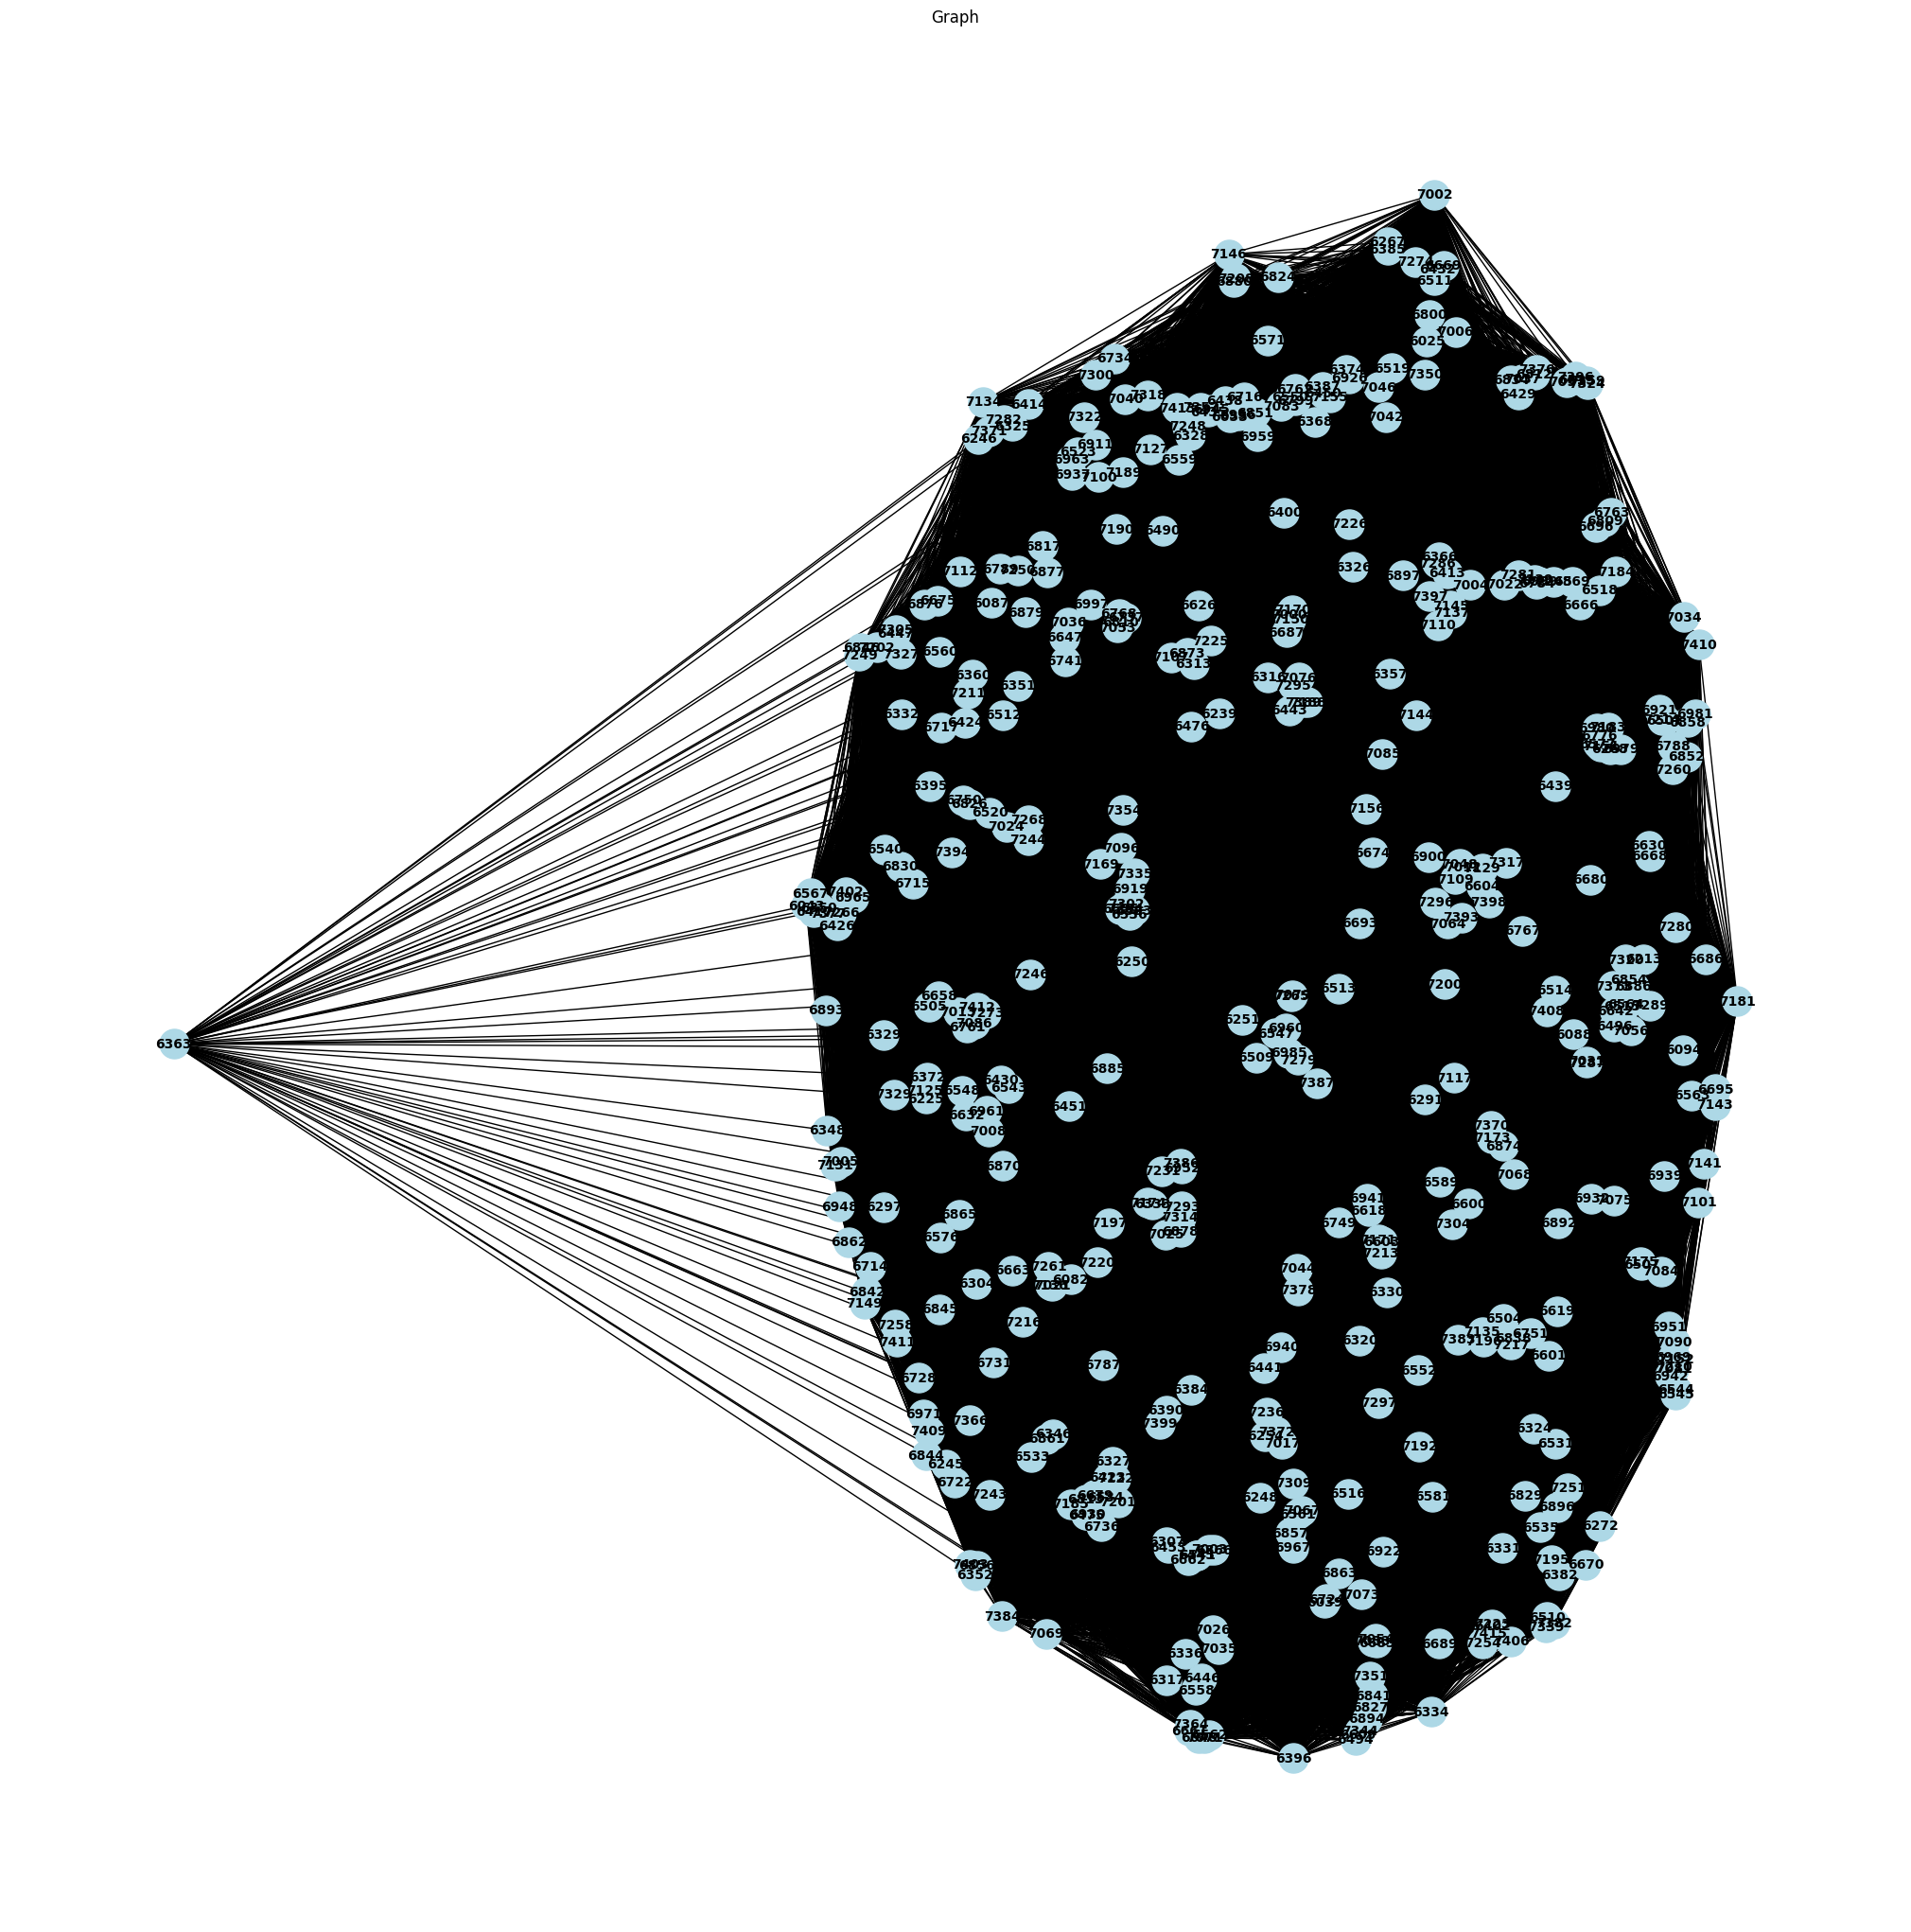

Graph Analysis:
Number of nodes: 455
Number of edges: 102576
Average degree: 450.88
Density: 0.993
Average shortest path length: 1.01
Diameter: 2

5 Largest Cliques:
	Clique 1: Size=419, Nodes=['6272', '6366', '6088', '6251', '6304', '6348', '6082', '6332', '6239', '6254', '6382', '6245', '6325', '6225', '6352', '6396', '6087', '6368', '6317', '6413', '6324', '6267', '6320', '6313', '6400', '6360', '6350', '6250', '6351', '6246', '6327', '6248', '6390', '6330', '6334', '6297', '6372', '6385', '6316', '6395', '6333', '6374', '6423', '6094', '6213', '6384', '6336', '6424', '6329', '6387', '6307', '7216', '7040', '6687', '7079', '7096', '6630', '6959', '6830', '6618', '7196', '7022', '6813', '6518', '6870', '6609', '6626', '7149', '6736', '6511', '7144', '6658', '6981', '6536', '6683', '6550', '7156', '7213', '6812', '7008', '7182', '7146', '6571', '6851', '6787', '7034', '6505', '6856', '7141', '6600', '6951', '6717', '6523', '7064', '7183', '6642', '6940', '7033', '7223', '7189', '7053'

In [13]:
filename = Path("symmetric_rtts.json")

G: nx.Graph = load_graph_from_json(filename)
visualize_graph(G, "Graph")
analyze_graph(G)
cliques = list(nx.find_cliques(G))
cliques.sort(key=len, reverse=True)
largest = set(cliques[0])

In [14]:

print("Carraghan-Pardalos experiment")
cp_solver: CarraghanPardalosCF = CarraghanPardalosCF(G)
max_clique_cp: set = cp_solver.find_maximum_clique()
intersection_set = largest.intersection(max_clique_cp)

# max_clique_cp = list(max_clique_cp)
# max_clique_cp.sort()
# largest = list(largest)
# largest.sort()
# for value1, value2 in zip(max_clique_cp, largest):
#     print(f"{value1} : {value2}")

print(f"Maximum clique {len(max_clique_cp)}: {max_clique_cp}")
print(f"CP intersection set {len(intersection_set)}: {intersection_set}")
print("-"*100)

print("Tabu-Search experiment")
tabu_solver: TabuCliqueFinder = TabuCliqueFinder(G)
max_clique_tabu: set = tabu_solver.find_maximum_clique()

cliques = list(nx.find_cliques(G))
cliques.sort(key=len, reverse=True)
largest = set(cliques[0])

intersection_set = largest.intersection(max_clique_tabu)

print(f"Maximum clique {len(max_clique_tabu)}: {max_clique_tabu}")
print(f"Tabu intersection set {len(intersection_set)}: {intersection_set}")
print("-"*100)


print("Bron-Kerbosh experiment")
bk_solver = BronKerbosch(G)
max_clique_bk: set = bk_solver.find_maximum_clique()
intersection_set = largest.intersection(max_clique_bk)

print(f"Maximum clique {len(max_clique_bk)} {type(max_clique_bk)}: {max_clique_bk}")
print(f"BK intersection set {len(intersection_set)}: {intersection_set}")
print("-"*100)

# print(f"Is BK and CP same: {max_clique_bk == max_clique_cp}")
# print(f"Is BK and Tabu same: {max_clique_bk == max_clique_tabu}")

# max_clique_bk = list(max_clique_bk)
# max_clique_cp = list(max_clique_cp)

# matched_nodes = set()
# for clique_bk in max_clique_bk:
#     for clique_cp in max_clique_cp:
#         if clique_bk == clique_cp:
#             matched_nodes.add(clique_bk)
#             break

# print(f"Matched nodes in BK and CP {len(matched_nodes)}: {matched_nodes}")

# data = {
#     "BK" : list(max_clique_bk),
#     "CP" : list(max_clique_cp),
#     "Tabu Search" : list(max_clique_tabu)
# }

# # create_comparison_table(data, "Correlation Table (Truncated)")


Carraghan-Pardalos experiment
find_maximum_clique took 21.3925442910 seconds to execute
Maximum clique 419: {'7184', '6272', '7216', '6869', '7231', '6519', '6922', '6877', '7397', '6648', '7040', '6515', '6581', '7005', '7371', '6534', '6687', '7079', '7096', '6250', '7150', '6662', '6630', '6874', '7073', '6959', '6830', '6520', '6618', '7196', '7022', '6632', '7068', '6879', '6426', '7155', '6813', '7378', '7296', '6518', '6323', '6870', '6351', '6328', '6930', '6246', '6366', '6626', '7294', '6609', '7149', '6327', '6736', '6443', '7190', '7100', '7359', '6501', '6511', '7387', '7144', '6658', '7354', '7135', '6981', '6937', '6536', '6683', '7293', '6550', '7156', '7249', '7003', '6844', '6604', '6812', '7213', '6509', '7026', '7008', '6878', '6088', '7373', '7182', '6661', '7137', '7146', '6571', '6438', '7403', '6985', '7309', '6851', '7393', '6939', '6402', '6390', '6025', '7129', '6635', '6787', '7136', '6861', '7413', '7386', '7034', '6505', '7173', '7266', '7244', '6827', '70

Tabu-Search experiment
find_maximum_clique took 0.1223 seconds to execute
Maximum clique 75: {'274', '261', '202', '223', '256', '239', '247', '222', '213', '265', '204', '232', '270', '230', '214', '236', '249', '227', '235', '237', '233', '253', '219', '245', '271', '262', '208', '252', '215', '207', '243', '216', '220', '264', '200', '255', '260', '229', '206', '257', '209', '211', '203', '250', '254', '267', '251', '224', '234', '210', '268', '205', '273', '218', '248', '241', '201', '238', '231', '246', '225', '259', '258', '221', '242', '240', '228', '226', '266', '272', '212', '269', '244', '263', '217'}
----------------------------------------------------------------------------------------------------
